In [36]:
# import relevant libraries
# allow output from every line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

'This analysis examines associations between receiving stats like Y/R, TDs, first downs, catch %, etc.\n and environmental factors like weather (temperature and wind) and surface for the 2023 NFL regular season. \n \n This program loads in two datasets, one containing player-level receiving data and one containing historical \n game logs, then cleans, preprocesses, aggregates, and manipulates them, producing a team-level merged dataframe\n with receiving statistics and environmental parameters from 2023. \n \n The script also generates descriptive and \n correlational visualizations throughout the analysis.'

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix for Player-Level Receiving Stats')

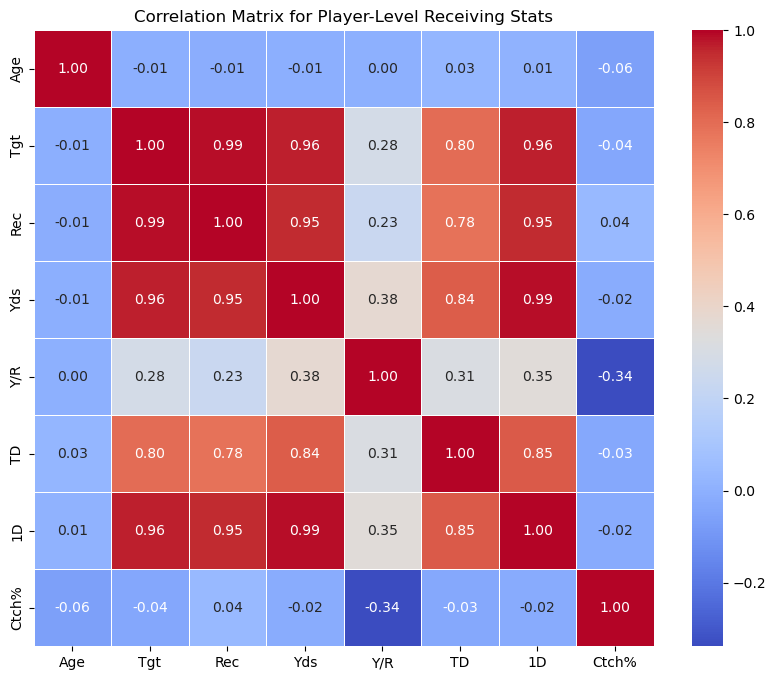

In [40]:
'''This analysis examines associations between receiving stats like Y/R, TDs, first downs, catch %, etc.
 and environmental factors like weather (temperature and wind) and surface for the 2023 NFL regular season. 
 
 This program loads in two datasets, one containing player-level receiving data and one containing historical 
 game logs, then cleans, preprocesses, aggregates, and manipulates them, producing a team-level merged dataframe
 with receiving statistics and environmental parameters from 2023. 
 
 The script also generates descriptive and 
 correlational visualizations throughout the analysis.'''


# load in receiving stats for 2023 NFL season. This dataset includes players listed as WR, TE, RB, and other cases where receptions were made (QB, LB, FB, etc.). Data acquired from https://www.pro-football-reference.com/years/2023/receiving.htm
nfl_receiving_23 = pd.read_csv('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/datasets/2023_NFL_receiving_stats.csv')

# include all players -- this will be grouped by team later
wr_23 = nfl_receiving_23

# select important parameters that may be impacted by climate and weather factors -- age, tgt, rec, yds, y/r, td, 1d, ctch%
wr_23 = wr_23.iloc[:, :14]
corr_columns = ['Age', 'Tgt', 'Rec', 'Yds', 'Y/R', 'TD', '1D', 'Ctch%'] # use these columns for correlation map

# convert catch rate to numeric
wr_23['Ctch%'] = pd.to_numeric(wr_23['Ctch%'].str.rstrip('%'))

# create a correlation matrix, then map this to heatmap to see which variables have strong associations
corr_matrix = wr_23[corr_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# save figure to repositories folder
plt.title('Correlation Matrix for Player-Level Receiving Stats')
plt.savefig('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/figures/player_correlations.pdf')
plt.show()

The correlation heatmap reveals that:
- Catch rate % doesn't correlate well with the other metrics.
- Targets, receptions, yards, 1st downs all have very strong correlations with each other, since these metrics are derived from each other.
- TD has a relatively strong correlation with targets, receptions, yards, and 1D. Unlike the other metrics, receiving TDs are not as strongly associated with the number of targets, receptions, or yards a receiver has; i.e., some receivers are bigger red zone threats than others, other receivers prioritize receptions and yards over TDs. 

Research Question:
Which environmental parameters are associated with select receiving statistics (Y/R, TD, 1D, Ctch%)?

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix for Team-Level Receiving Stats')

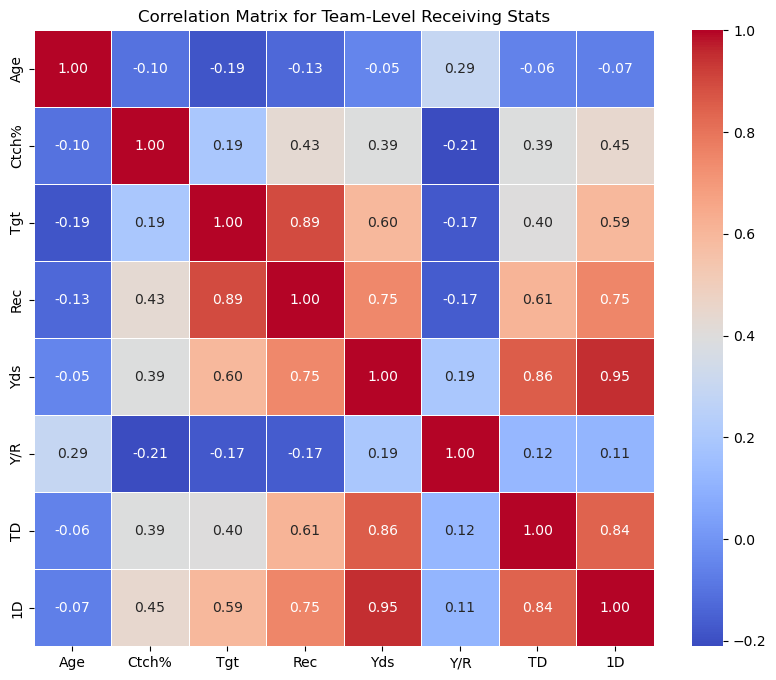

In [41]:
# aggregate by team, then visualize by team.

# drop rank, player, position, G, GS columns
wr_23 = wr_23.drop(['Rk', 'Player', 'Pos', 'G', 'GS'], axis=1)

# group by team. take the sum for targets, receptions, yds, td, and 1d; take the mean for age, catch%, and y/r
# use agg to get both means and sums
team_wr_23 = wr_23.groupby('Tm').agg({
    'Age': 'mean',
    'Ctch%': 'mean',
    'Tgt': 'sum',
    'Rec': 'sum',
    'Yds': 'sum',
    'Y/R': 'mean',
    'TD': 'sum',
    '1D': 'sum'
}).reset_index()

# drop 2TM and 3TM rows
team_wr_23 = team_wr_23.drop([0, 1], axis=0).reset_index(drop=True)

# create a correlation matrix for team level stats
team_corr_matrix = team_wr_23.select_dtypes(include=[np.number]).corr() # exclude team name column

# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(team_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Team-Level Receiving Stats')
plt.savefig('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/figures/team_correlations.pdf')
plt.show()

# Team Descriptive Analysis

<Axes: xlabel='Tm'>

Text(0.5, 1.0, 'Targets and Receptions by Team')

Text(0.5, 0, 'Team')

Text(0, 0.5, 'Count')

<Axes: xlabel='Tm'>

Text(0.5, 1.0, 'Normalized Receiving Metrics by Team')

Text(0.5, 0, 'Team')

Text(0, 0.5, 'Normalized Value')

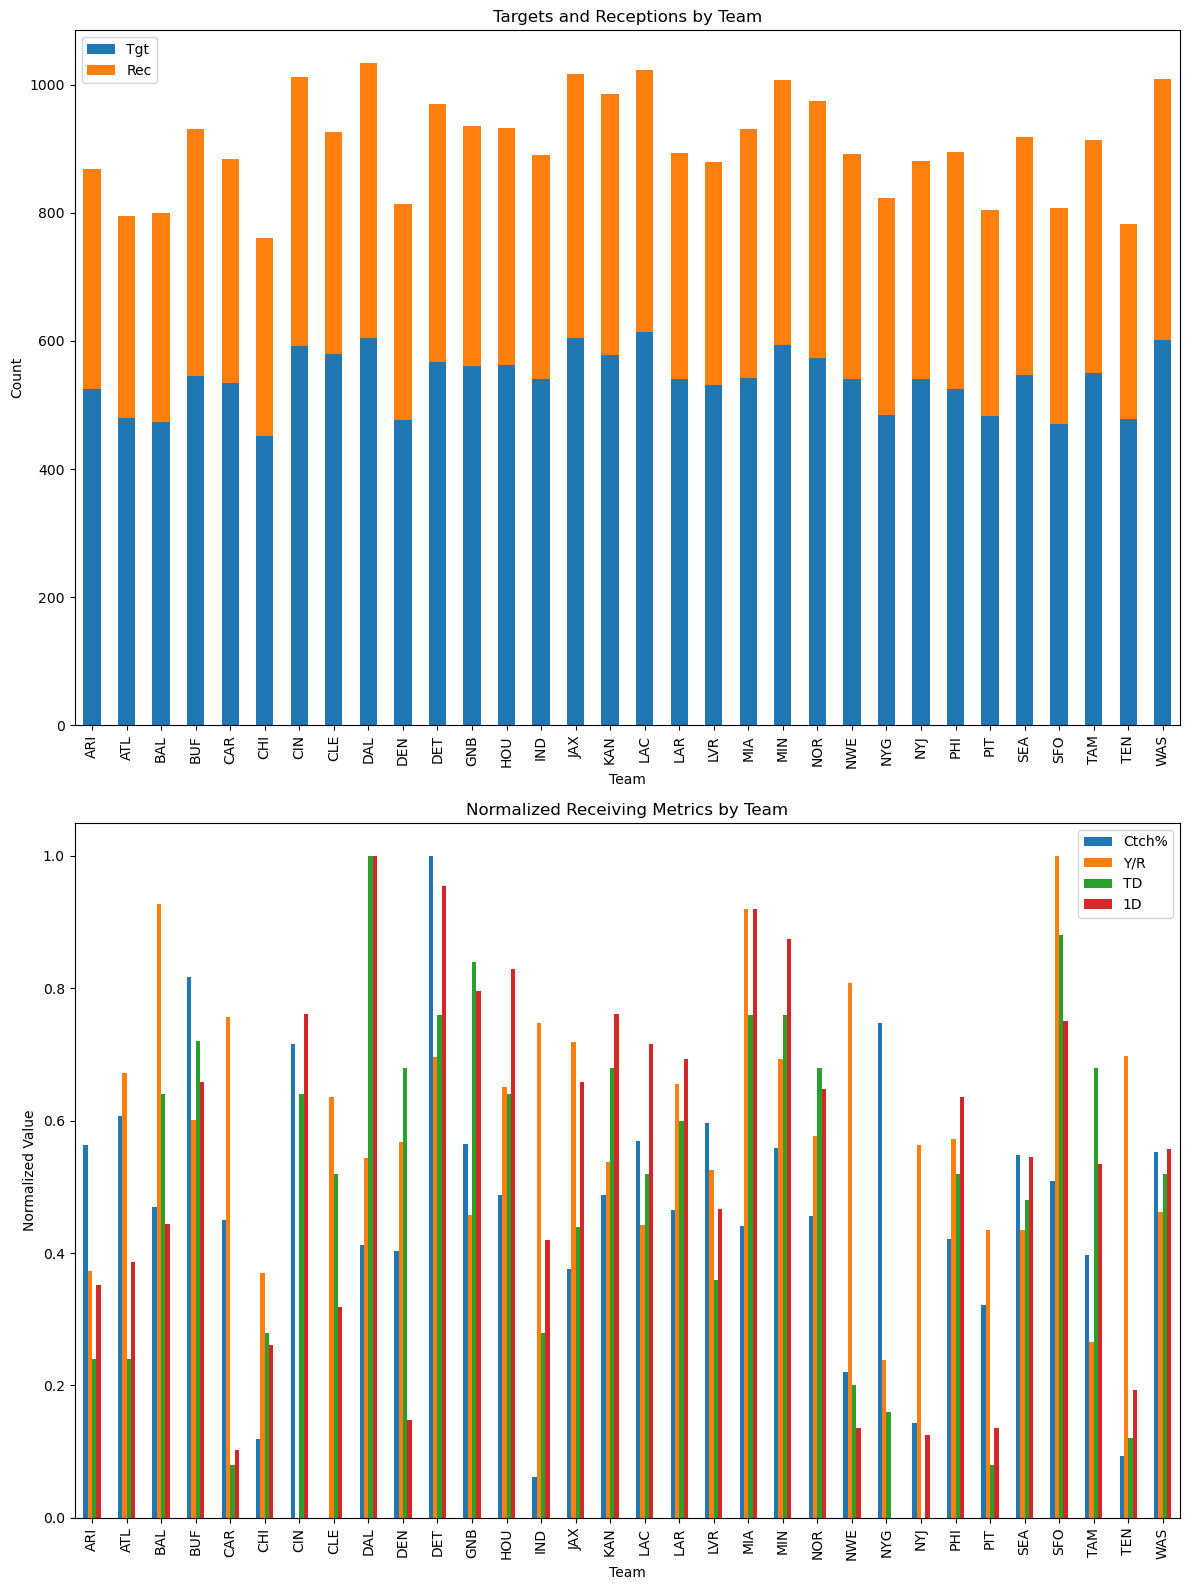

In [42]:
## descriptive analysis -- make grouped bar plot to compare team offenses based on WR stats

# drop yds and age for better viewability
team_wr_23 = team_wr_23.drop(['Yds', 'Age'], axis=1)

# new dataframe for targets and receptions
targets_receptions = team_wr_23[['Tm', 'Tgt', 'Rec']]

# new dataframe for remaining performance metrics
performance_stats = team_wr_23[['Tm', 'Ctch%', 'Y/R', 'TD', '1D']]

# normalize performance stats. Subtract the minimum value from each element in the dataframe, then divide by the range for each column.
# normalizes data on a scale from 0-1
normalized_performance = (performance_stats.set_index('Tm') - performance_stats.set_index('Tm').min()) / \
                         (performance_stats.set_index('Tm').max() - performance_stats.set_index('Tm').min())

# create a figure for both plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# plot targets vs. receptions
targets_receptions.set_index('Tm').plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Targets and Receptions by Team')
ax1.set_xlabel('Team')
ax1.set_ylabel('Count')

# plot remaining receiving performance metrics
normalized_performance.plot(kind='bar', ax=ax2)
ax2.set_title('Normalized Receiving Metrics by Team')
ax2.set_xlabel('Team')
ax2.set_ylabel('Normalized Value')

# adjust layout and save as pdf
plt.tight_layout()
plt.savefig('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/figures/team_descriptives.pdf')
plt.show()

# Weather vs. Performance Stats

In [43]:
## load in game/weather/surface data, aggregate that dataframe then join by team. ONLY USE DATA FROM OUTDOOR GAMES

# load in game-level historical data. Data acquired from https://github.com/nflverse/nfldata/blob/master/data/games.csv
nfl_games = pd.read_csv('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/datasets/games.csv')

# filter for 2023 NFL season, regular season only
games_23 = nfl_games[nfl_games['game_id'].str.contains('2023')]
games_23 = games_23[games_23['game_type'].str.contains('REG')]

# keep game_id, away_team, away_score, home_team, home_score, roof, surface, temp, wind
keep_columns = ['game_id', 'away_team', 'away_score', 'home_team', 'home_score', 'roof', 'surface', 'temp', 'wind']
games_23 = games_23[keep_columns]

# convert roof and surface to bool. set "outdoors" and "grass" as true, else false
games_23['roof'] = games_23['roof'].apply(lambda x: True if str(x).lower() == 'outdoors' else False)
games_23['surface'] = games_23['surface'].apply(lambda x: True if str(x).lower() == 'grass' else False)

# drop games played indoors and reset the index
games_23 = games_23[games_23['roof']]
games_23.reset_index(drop=True, inplace=True)

# rename to 'outdoor' and 'grass' for clarity
games_23 = games_23.rename(columns={'roof': 'outdoor', 'surface': 'grass'})


## drop and impute NaNs

# impute a specific value (0 for wind, 72 for temp) for indoor stadiums with NaNs
games_23.loc[(games_23['outdoor'] == False) & (games_23['temp'].isna()), 'temp'] = 72
games_23.loc[(games_23['outdoor'] == False) & (games_23['wind'].isna()), 'wind'] = 0

# for all other NaNs, impute the mean value for the respective column
numeric_mean = games_23.select_dtypes(include='number').mean()
games_23.fillna(numeric_mean, inplace=True)
games_23.reset_index(drop=True, inplace=True) # reset the index

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: xlabel='temp', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Temps (F) for Outdoor Games')

<Axes: >

<Axes: xlabel='wind', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Wind Speeds (mph) for Outdoor Games')

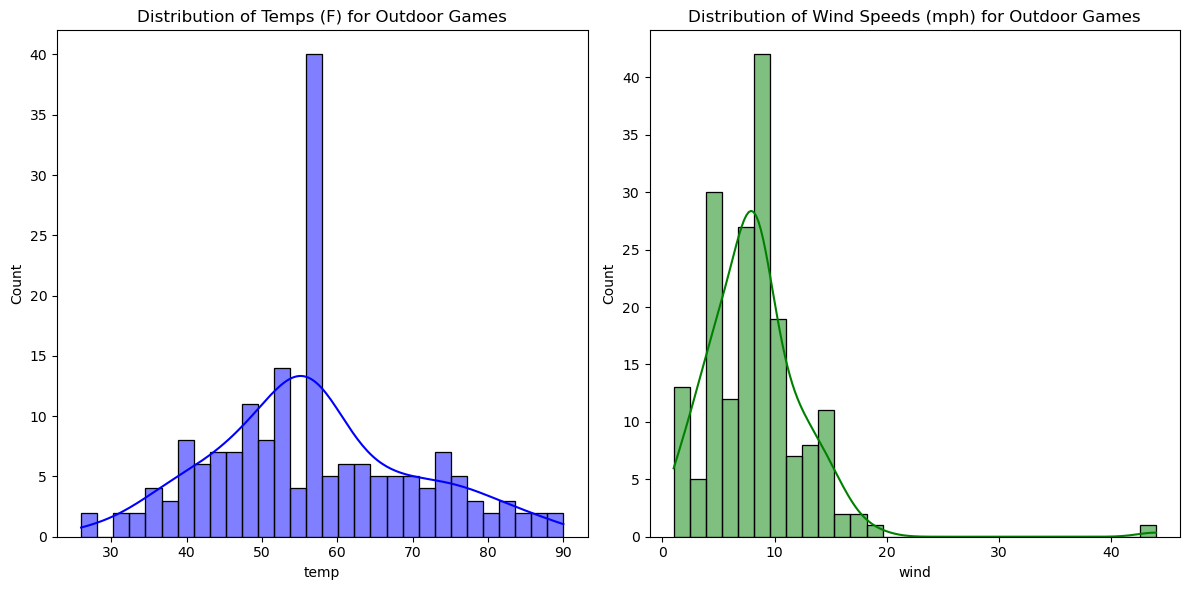

In [44]:
# check the distributions of temp and wind columns

plt.figure(figsize=(12, 6))

# histogram for temp
plt.subplot(1, 2, 1)
sns.histplot(games_23['temp'], bins=30, kde=True, color='blue')
plt.title('Distribution of Temps (F) for Outdoor Games')

# histogram for wind speed
plt.subplot(1, 2, 2)
sns.histplot(games_23['wind'], bins=30, kde=True, color='green')
plt.title('Distribution of Wind Speeds (mph) for Outdoor Games')

plt.tight_layout()
plt.savefig('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/figures/weather_distributions.pdf')
plt.show()

From these histograms, both temperature and wind follow a normal distribution.
- Bins for temp: cold (25-54), moderate (55-62), warm (63-75), hot (>75)
- Bins for wind speed: slow (0-6), moderate (7-11), fast (>11)

In [45]:
## based on the above distributions, create classifications for temperature and wind variables

# classify temp into four bins: cold, moderate, warm, hot
temp_bins = [25, 54, 62, 75, np.inf]

# classify wind speed into three bins: slow, moderate, fast
wind_bins = [0, 6, 11, np.inf]

# assign labels
temp_labels = ['cold', 'moderate', 'warm', 'hot']
wind_labels = ['slow', 'medium', 'fast']

# apply bins and labels, create new categorical columns
games_23['temp_category'] = pd.cut(games_23['temp'], bins=temp_bins, labels=temp_labels, right=False)
games_23['wind_category'] = pd.cut(games_23['wind'], bins=wind_bins, labels=wind_labels, right=False)

# group by home team, calculate counts for each condition
homegames_outdoor = games_23.groupby('home_team').agg({
    'grass': 'first',
    'game_id': 'count',
    'temp_category': lambda x: x.value_counts().to_dict(),
    'wind_category': lambda x: x.value_counts().to_dict()
}).reset_index()

# rename columns
homegames_outdoor.rename(columns={'game_id': 'total_games', 'temp_category': 'temp_counts', 'wind_category': 'wind_counts'}, inplace=True)

# iterate through the labels, creating new columns with a count of games for each condition
for condition in temp_labels + wind_labels:
    column_name = f'number {condition} games'
    homegames_outdoor[column_name] = homegames_outdoor['temp_counts'].apply(lambda x: x.get(condition, 0)) + homegames_outdoor['wind_counts'].apply(lambda x: x.get(condition, 0))

# drop temporary columns
homegames_outdoor.drop(['temp_counts', 'wind_counts'], axis=1, inplace=True)

In [46]:
# now group by away teams and calculate counts for each condition
awaygames_outdoor = games_23.groupby('away_team').agg({
    'grass': 'first',
    'game_id': 'count',
    'temp_category': lambda x: x.value_counts().to_dict(),
    'wind_category': lambda x: x.value_counts().to_dict()
}).reset_index()

# rename columns
awaygames_outdoor.rename(columns={'game_id': 'total_games', 'temp_category': 'temp_counts', 'wind_category': 'wind_counts'}, inplace=True)

# iterate through the labels, creating new columns with a count of games for each condition
for condition in temp_labels + wind_labels:
    column_name = f'number {condition} games'
    awaygames_outdoor[column_name] = awaygames_outdoor['temp_counts'].apply(lambda x: x.get(condition, 0)) + awaygames_outdoor['wind_counts'].apply(lambda x: x.get(condition, 0))

# drop temporary columns
awaygames_outdoor.drop(['temp_counts', 'wind_counts'], axis=1, inplace=True)

In [47]:
# rename team columns to 'team', then join dataframes on team
homegames_outdoor.rename(columns={'home_team': 'Tm'}, inplace=True)
awaygames_outdoor.rename(columns={'away_team': 'Tm'}, inplace=True)
outdoor_games_23 = homegames_outdoor.merge(awaygames_outdoor, on='Tm', how='outer', suffixes=('_home', '_away'))

# drop field surface for this analysis
outdoor_games_23.drop(['grass_home', 'grass_away'], axis=1, inplace=True)

In [48]:
# ONLY denotes games played outdoors, both home and away

# NaN values represent teams whose home stadium is indoors -- number of total home outdoor games is therefore 0
outdoor_games_23.fillna(0, inplace=True)

# combine home and away games for 'total' columns for each category
keywords = ['cold', 'moderate', 'warm', 'hot', 'slow', 'medium', 'fast']

for keyword in keywords:
    home_col = f'number {keyword} games_home'
    away_col = f'number {keyword} games_away'
    combined_total = f'total {keyword} games'
    
    # sum home and away games
    outdoor_games_23[combined_total] = outdoor_games_23[home_col] + outdoor_games_23[away_col]

# drop home and away columns
outdoor_games_23.drop([f'number {keyword} games_home' for keyword in keywords], axis=1, inplace=True)
outdoor_games_23.drop([f'number {keyword} games_away' for keyword in keywords], axis=1, inplace=True)

# make total outdoor games column
outdoor_games_23['total outdoor games'] = outdoor_games_23['total_games_home'] + outdoor_games_23['total_games_away']
outdoor_games_23.drop(['total_games_home', 'total_games_away'], axis=1, inplace=True)

# reorder and reorganize columns
column_order = ['Tm', 'total outdoor games', 'total cold games', 'total moderate games', 'total warm games', 'total hot games', 'total slow games', 'total medium games', 'total fast games']
outdoor_games_23 = outdoor_games_23[column_order]

In [49]:
# map acronyms across dataframes for consistency
acronym_map = {
    'GNB': 'GB',
    'KAN': 'KC',
    'LAR': 'LA',
    'LVR': 'LV',
    'NOR': 'NO',
    'NWE': 'NE',
    'SFO': 'SF',
    'TAM': 'TB'
}

team_wr_23['Tm'] = team_wr_23['Tm'].replace(acronym_map) # change team acronyms to match with games dataframe

In [50]:
# merge outdoor games dataframe with team receiving stats dataframe
outdoor_receiving_stats = outdoor_games_23.merge(team_wr_23, on='Tm', how='outer')

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix for Team Receiving Stats and Games Played in Varying Weather Conditions')

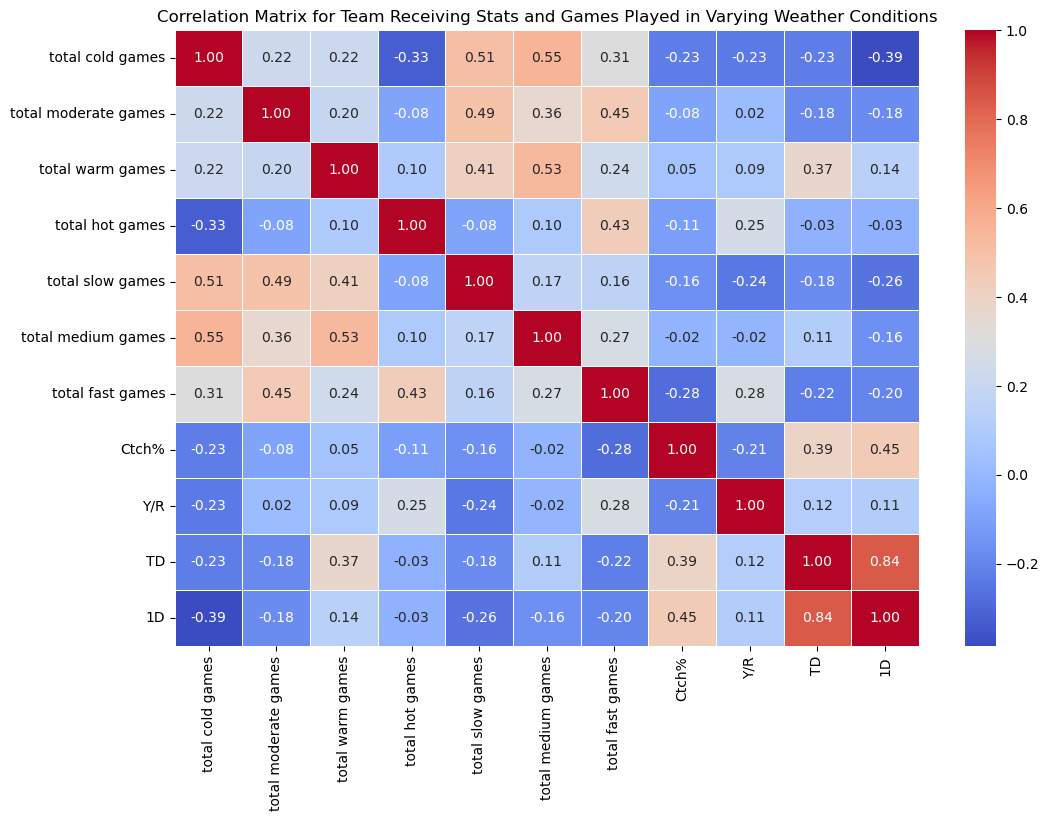

In [51]:
# plot correlation matrix to view associations
correlation_matrix = outdoor_receiving_stats[['total cold games', 'total moderate games', 'total warm games', 'total hot games', 'total slow games', 'total medium games', 'total fast games', 'Ctch%', 'Y/R', 'TD', '1D']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Team Receiving Stats and Games Played in Varying Weather Conditions')
plt.savefig('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/figures/receiving_weather_correlations.pdf')
plt.show()

# Surface vs. Performance Stats

In [52]:
# Analysis for surface vs. performance stats. Include both indoor and outdoor settings

# filter for 2023 NFL season, regular season only
surfaces_23 = nfl_games[nfl_games['game_id'].str.contains('2023')]
surfaces_23 = surfaces_23[surfaces_23['game_type'].str.contains('REG')]

# keep game_id, away_team, away_score, home_team, home_score, surface
keep_columns = ['game_id', 'away_team', 'away_score', 'home_team', 'home_score', 'surface'] # exclude roof
surfaces_23 = surfaces_23[keep_columns]

# convert surface to bool, set "grass" as true, else false
surfaces_23['surface'] = surfaces_23['surface'].apply(lambda x: True if str(x).lower() == 'grass' else False)

# create a new DataFrame with the relevant columns
surface_counts = surfaces_23[['home_team', 'away_team', 'surface']]

# combine 'home_team' and 'away_team' columns into a single 'team' column for home games
teams_home = surface_counts['home_team']
surface_counts.loc[:, 'team_home'] = teams_home.values

# combine 'home_team' and 'away_team' columns into a single 'team' column for away games
teams_away = surface_counts['away_team']
surface_counts.loc[:, 'team_away'] = teams_away.values

# drop the original 'home_team' and 'away_team' columns
surface_counts = surface_counts.drop(['home_team', 'away_team'], axis=1)

# sum the number of grass and turf games for each team for home games
surface_counts_home = surface_counts.groupby('team_home')['surface'].value_counts().unstack().fillna(0)
surface_counts_home.columns = ['number of games played on turf', 'number of games played on grass']

# sum the number of grass and turf games for each team for away games
surface_counts_away = surface_counts.groupby('team_away')['surface'].value_counts().unstack().fillna(0)
surface_counts_away.columns = ['number of games played on turf', 'number of games played on grass']

# reset index for both dataframes
surface_counts_home.reset_index(inplace=True)
surface_counts_away.reset_index(inplace=True)

# merge dataframes on "team"
total_surface_counts = pd.merge(surface_counts_home, surface_counts_away, left_on='team_home', right_on='team_away', how='outer')

# rename columns
total_surface_counts = total_surface_counts[['team_home', 'number of games played on grass_x', 'number of games played on turf_x', 'number of games played on grass_y', 'number of games played on turf_y']]
total_surface_counts.columns = ['team', 'games grass_home', 'games turf_home', 'games grass_away', 'games turf_away']

# combine the number of games played on grass and turf for home and away games
total_surface_counts['games grass'] = total_surface_counts['games grass_home'] + total_surface_counts['games grass_away']
total_surface_counts['games turf'] = total_surface_counts['games turf_home'] + total_surface_counts['games turf_away']

# drop repeated columns
total_surface_counts = total_surface_counts[['team', 'games grass', 'games turf']]


/var/folders/8q/xlh091t94ggblq59jbqdyp8m0000gn/T/ipykernel_51696/108386101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surface_counts.loc[:, 'team_home'] = teams_home.values
/var/folders/8q/xlh091t94ggblq59jbqdyp8m0000gn/T/ipykernel_51696/108386101.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surface_counts.loc[:, 'team_away'] = teams_away.values


In [53]:
# rename "team" to "Tm" for consistency across dataframes
total_surface_counts = total_surface_counts.rename(columns={'team': 'Tm'})

# merge surface dataframe with team receiving stats dataframe
surfaces_stats = total_surface_counts.merge(team_wr_23, on='Tm', how='outer')

<Axes: xlabel='Tm', ylabel='games grass'>

<Axes: xlabel='Tm', ylabel='games turf'>

<Axes: xlabel='Tm', ylabel='TD_normalized'>

Text(0.5, 1.0, 'Number of Games on Grass, Turf, and TDs by Team')

Text(0.5, 0, 'Team')

Text(0, 0.5, 'Number of Games / TDs')

<Axes: xlabel='Tm', ylabel='games grass'>

<Axes: xlabel='Tm', ylabel='games turf'>

<Axes: xlabel='Tm', ylabel='1D_normalized'>

Text(0.5, 1.0, 'Number of Games on Grass, Turf, and 1Ds by Team')

Text(0.5, 0, 'Team')

Text(0, 0.5, 'Number of Games / 1Ds')

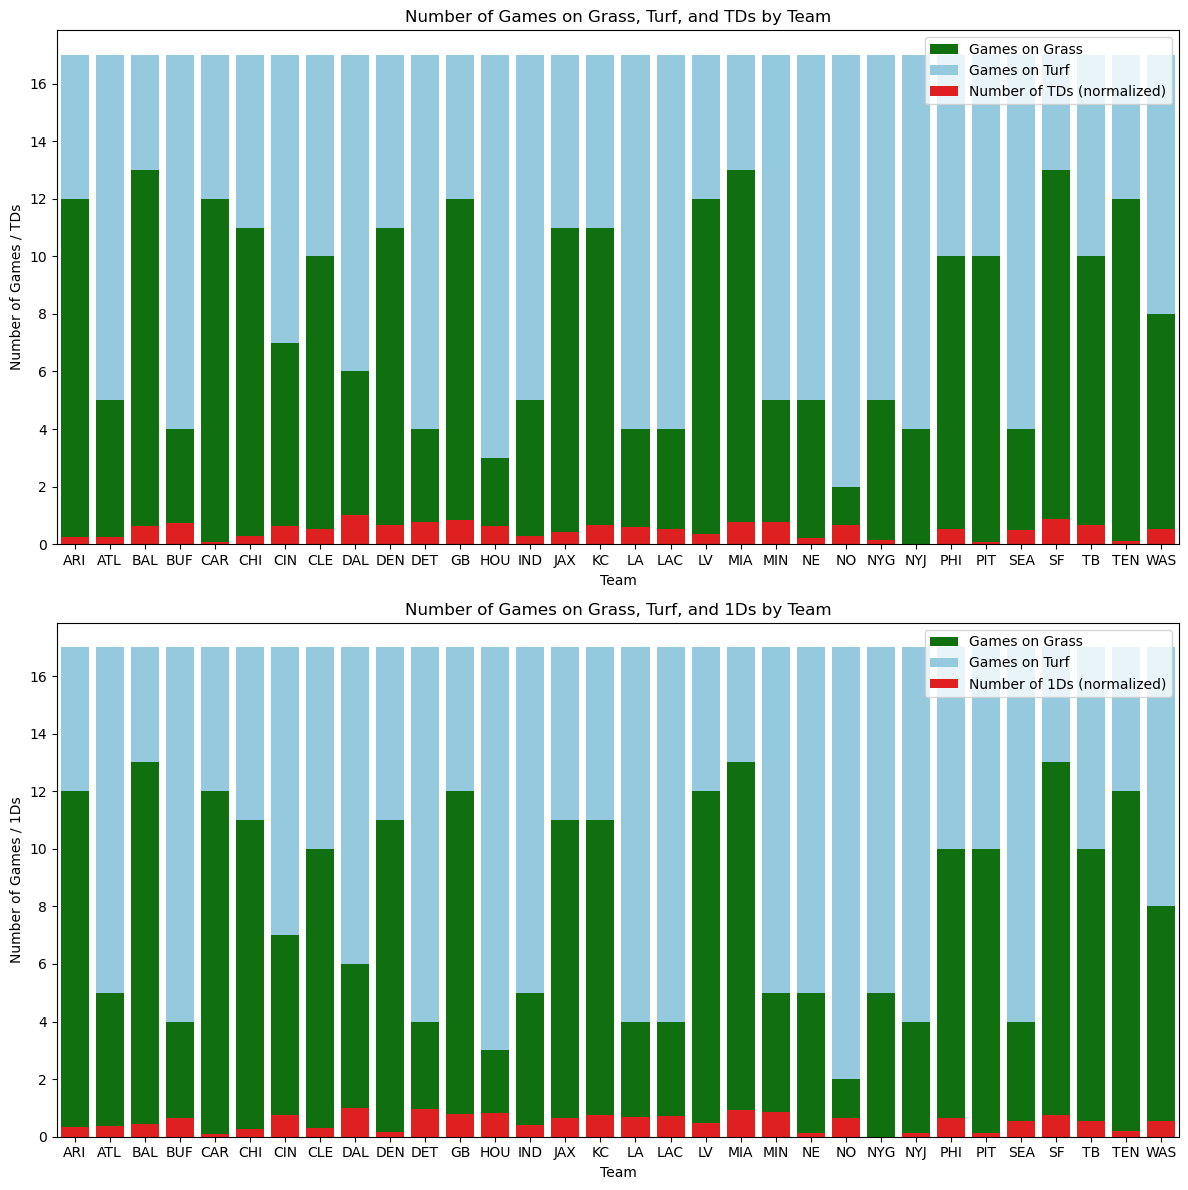

In [54]:
# plot stacked bar plots for select metrics

# evaluate TDs and 1Ds

# scale 1Ds down using sk learn
scaler = MinMaxScaler()

# normalize 'TD' and '1D' columns
surfaces_stats['TD_normalized'] = scaler.fit_transform(surfaces_stats[['TD']])
surfaces_stats['1D_normalized'] = scaler.fit_transform(surfaces_stats[['1D']])

# create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# plot number of games on grass, turf, and number of TDs
sns.barplot(x='Tm', y='games grass', data=surfaces_stats, color='green', ax=axes[0], label='Games on Grass')
sns.barplot(x='Tm', y='games turf', data=surfaces_stats, color='skyblue', ax=axes[0], bottom=surfaces_stats['games grass'], label='Games on Turf')
sns.barplot(x='Tm', y='TD_normalized', data=surfaces_stats, color='red', ax=axes[0], label='Number of TDs (normalized)')
axes[0].set_title('Number of Games on Grass, Turf, and TDs by Team')
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Number of Games / TDs')
axes[0].legend()

# plot number of games for each surface and number of 1Ds
sns.barplot(x='Tm', y='games grass', data=surfaces_stats, color='green', ax=axes[1], label='Games on Grass')
sns.barplot(x='Tm', y='games turf', data=surfaces_stats, color='skyblue', ax=axes[1], bottom=surfaces_stats['games grass'], label='Games on Turf')
sns.barplot(x='Tm', y='1D_normalized', data=surfaces_stats, color='red', ax=axes[1], label='Number of 1Ds (normalized)')
axes[1].set_title('Number of Games on Grass, Turf, and 1Ds by Team')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Number of Games / 1Ds')
axes[1].legend()

# adjust figure, save, and show
plt.tight_layout()
plt.savefig('/Users/reesemichaels/Library/CloudStorage/OneDrive-SyracuseUniversity/SAL 603/repositories/FinalProject/figures/surface_tds_1ds.pdf')
plt.show()